# Introduction
<hr/>

In machine learning, **binary classification** is a <u>supervised</u> algorithm that categorizes images into one of two classes. You provide two datasets of images (A and B), a **label** for each one (happy and sad), and the algorithm will learn from it classifying both label in  0 or 1, being able to predict whether the sample belongs to 0 (class A) or 1 (class B).

## One class classification
<hr>

Doubtless, binary classification is widely spread, and it does work well in many scenarios. But, what if I just want to be able to recognize one single image? To make it clear, consider the problem of determining whether a fingerprint exists in an image or not. You create a dataset with several of fingerprints you would like to train the model to recognize, but what about the instances of "Not Fingerprint" images? Instances of "Not Fingerprint" are nearly infinite.

To overcome this problem, we going to use **one class classification** and **Convolutional Neural Networks(CNN)**. In this paradigm, the classifier is given a sample and say if it belongs to class A or is an <u>outlier</u>.

## Outlier
<hr>
An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. A picture is worth a thousand words:

![outlier](https://www.smarten.com/wp-content/uploads/2018/06/what-is-outlier-analysis-2.jpg)

They differ significantly from other observations.

# Dataset
<hr>

The dataset is composed of the original [NIST Special Database 4. NIST 8-Bit Gray Scale Images of Fingerprint Image Groups](https://www.nist.gov/publications/nist-special-database-4-nist-8-bit-gray-scale-images-fingerprint-image-groups) as well as [Sokoto Coventry Fingerprint Dataset (SOCOFing)](https://www.kaggle.com/datasets/ruizgara/socofing). Random images dataset is composed of [Image Captioning Dataset, Random Images](https://www.kaggle.com/datasets/shamsaddin97/image-captioning-dataset-random-images) plus other random images from Google Images.

Around 2300 for each dataset.

# Dependencies and setup
<hr>

In [6]:
import os

`os` is a built-in Python module that provides functions for interacting with the operating system, like creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.

In [38]:
import cv2

`cv2` called *OpenCV*, is a huge open-source library for computer vision, machine learning, and image processing.

In [1]:
import imghdr

`imghdr` module determines the type of image contained in a file or byte stream.

In [6]:
import numpy as np

`numpy` is a module used for working with multidimensional arrays, as well as variations such as masks and matrices, which can be used for various math operations.

"But python doesn't have its own arrays? Why do people use numpy so much?" you may ask. Quite simply, it’s faster than regular Python arrays. Another reason is that numpy arrays and operations are vectorized, which means they lack explicit looping or indexing in the code. This makes the code not only more readable but also more similar to standard mathematical notation. For two arrays A and B of the same size, if we wanted to do a vector multiplication in Python:

```python
c = []
for i in range(len(a)):
    c.append(a[i]*b[i])
```

In numpy, this can simply be done with the following line of code:

```python
c = a * b
```
Numpy makes many mathematical operations used widely in **scientific computing** fast and easy to use, such as: vector-vector multiplication; matrix-matrix and matrix-vector multiplication; element-wise operations on vectors and matrices (i.e., adding, subtracting, multiplying, and dividing by a number); element-wise or array-wise comparisons; applying functions element-wise to a vector/matrix (like pow, log, and exp); reduction, statistics, and much more.

When speaking of a digital image, we are speaking of a matrix so numpy is extremely important for us.

In [4]:
import matplotlib.pyplot as plt

`matplotlib` provides a high-level interface for plotting attractive and informative statistical graphics.

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import tensorflow as tf

`tensorflow` is an open source library for numerical computation that makes machine learning faster and easier. `keras` is on top of TensorFlow and is tightly integrated with it. Keras is a neural network API that is used to build machine learning models. `layers` are a set of 'neurons' of an artificial neural network.

# Remove dodgy images
<hr>

In [39]:
data_dir = 'dataset' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            print(e)

Image not in ext list dataset/non-fingerprint/random-forest-diagram.svg
Image not in ext list dataset/non-fingerprint/9ecf13574f851420eacecf6f02.jpg
Image not in ext list dataset/non-fingerprint/Lost-in-Random-Shadowman-screenshot.jpg
Image not in ext list dataset/non-fingerprint/3474.jpg
Image not in ext list dataset/non-fingerprint/image_captions.csv
Image not in ext list dataset/non-fingerprint/687.jpg
Image not in ext list dataset/non-fingerprint/4242.jpg
Image not in ext list dataset/non-fingerprint/3672.jpg
Image not in ext list dataset/non-fingerprint/3844134-2.jpg
Image not in ext list dataset/non-fingerprint/random3.gif
Image not in ext list dataset/non-fingerprint/aaf9d35395842b741714336cc9.jpg
Image not in ext list dataset/non-fingerprint/RandomShape_Lead_615x344.gif
Image not in ext list dataset/non-fingerprint/memes-meme.gif
Image not in ext list dataset/non-fingerprint/1663565358random-numbers-js.jpg
Image not in ext list dataset/non-fingerprint/soccer-random2.webp
Image 

# Load and scale data
<hr>

In [43]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 4756 files belonging to 2 classes.


In [44]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

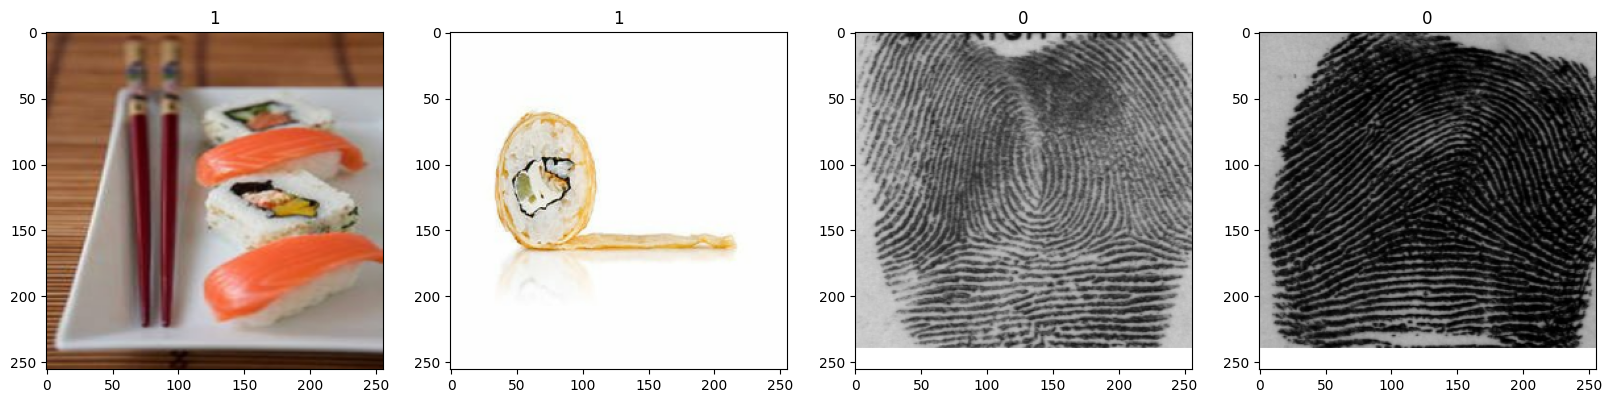

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

In [46]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

# Split data
<hr>

In [47]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [48]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build the Artificial Neural Network (ANN), Deep Learning Model
<hr>

In [49]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# Train the model
<hr>

In [52]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
104/104 [==============================] - 26s 238ms/step - loss: 0.1302 - accuracy: 0.9390 - val_loss: 0.0044 - val_accuracy: 0.9989
Epoch 2/20
104/104 [==============================] - 27s 253ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 0.9989
Epoch 3/20
104/104 [==============================] - 25s 236ms/step - loss: 3.5233e-04 - accuracy: 1.0000 - val_loss: 4.8841e-05 - val_accuracy: 1.0000
Epoch 4/20
104/104 [==============================] - 25s 236ms/step - loss: 2.8274e-04 - accuracy: 1.0000 - val_loss: 2.2089e-04 - val_accuracy: 1.0000
Epoch 5/20
104/104 [==============================] - 25s 236ms/step - loss: 1.2579e-04 - accuracy: 1.0000 - val_loss: 5.9162e-04 - val_accuracy: 1.0000
Epoch 6/20
104/104 [==============================] - 25s 237ms/step - loss: 1.0812e-04 - accuracy: 1.0000 - val_loss: 1.7070e-04 - val_accuracy: 1.0000
Epoch 7/20
104/104 [==============================] - 25s 238ms/step - loss: 9.1819e-05 - accuracy

# Plot model
<hr>

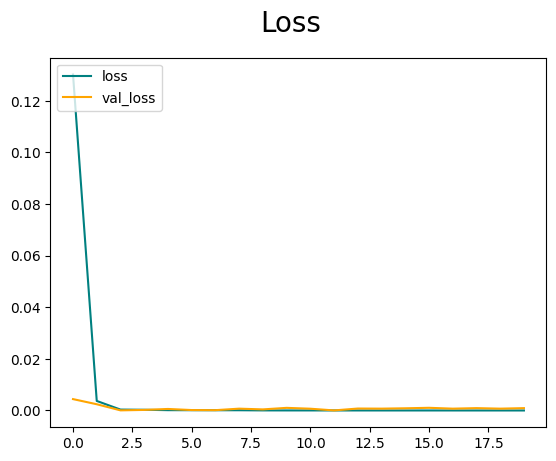

In [53]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()